<a href="https://colab.research.google.com/github/Sowmyabose/LUNGPROJECT24/blob/main/SVM_AND_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Reading images from class directory: Normal cases
Reading images from class directory: Malignant cases
Reading images from class directory: Bengin cases
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5083 - loss: 1.8179 - val_accuracy: 0.5091 - val_loss: 0.9873
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6129 - loss: 1.0008 - val_accuracy: 0.5091 - val_loss: 0.9990
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6772 - loss: 0.7654 - val_accuracy: 0.5091 - val_loss: 0.9646
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7062 - loss: 0.7212 - val_accuracy: 0.5091 - val_loss: 0.9552
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7262 - loss: 0.6699 - val_accuracy: 0.5091 - val_loss: 0.9561
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7670 - loss: 0.5574 - val_accuracy: 0.5091 - val_loss: 1.0193
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7880 - loss: 0.5124 - v

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 608ms/step - accuracy: 0.9979 - loss: 0.1157
Test Loss: 0.12165908515453339, Test Accuracy: 0.996363639831543


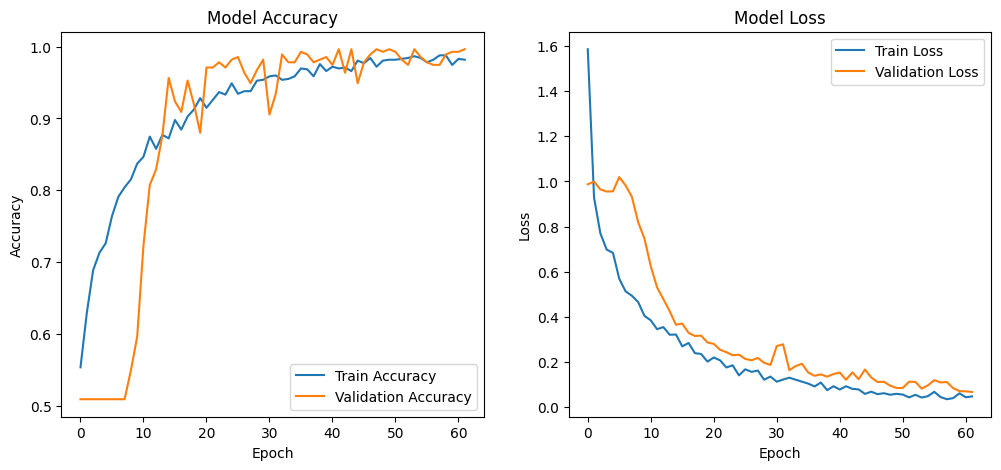

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step


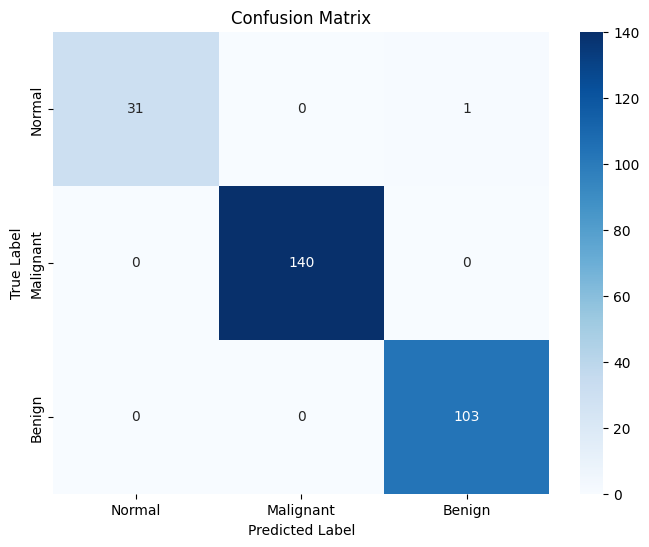

In [3]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ReLU, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools

# Parameters
dataset_path = '/content/drive/MyDrive/project dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
input_shape = (128, 128, 3)
num_classes = 3  # Normal, Benign, Malignant
class_names = ['Normal', 'Malignant', 'Benign']
class_mapping = {class_name: index for index, class_name in enumerate(class_names)}

# Load and preprocess images
images = []
labels = []

for class_dir in os.listdir(dataset_path):
    class_dir_path = os.path.join(dataset_path, class_dir)
    if os.path.isdir(class_dir_path):
        print(f"Reading images from class directory: {class_dir}")
        for image_file in os.listdir(class_dir_path):
            image_path = os.path.join(class_dir_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img = img.resize(input_shape[:2])
                    img = np.array(img)
                    if img.shape == input_shape:
                        images.append(img)
                        labels.append(class_dir)  # Folder names are class labels
                    else:
                        print(f"Image {image_path} skipped due to shape mismatch.")
            except Exception as e:
                print(f"Error reading image {image_path}: {e}")

images = np.array(images, dtype=np.float32) / 255.0  # Normalize image data to 0-1

# Convert labels to categorical
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded, num_classes=num_classes)

# Shuffle dataset
shuffled_indices = np.arange(images.shape[0])
np.random.shuffle(shuffled_indices)
images = images[shuffled_indices]
labels = labels[shuffled_indices]

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.25, random_state=42)

# Define the CNN-SVM Model
inputs = Input(shape=input_shape)

# First layer
x = Conv2D(64, (3,3), padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Residual block
shortcut = x
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, shortcut])
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Additional layers with Dropout
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
features = Dense(256, activation='relu')(x)
x = Dropout(0.5)(features)
svm_output = Dense(num_classes, activation='softmax')(x)  # SVM classifier

# Create model
model = Model(inputs, svm_output)
opt = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=20, mode="max", restore_best_weights=True),
    ModelCheckpoint(filepath='model.h5.keras', monitor='val_accuracy', save_best_only=True)
]

# Train the model
history = model.fit(train_images, train_labels, callbacks=callbacks, batch_size=16, epochs=80, validation_data=(test_images, test_labels))
model.save('model.h5')

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict labels and generate confusion matrix
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
